In [1]:
import pandas as pd
from imblearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn import preprocessing
import numpy


Using TensorFlow backend.


# Read Dataset

In [2]:
df = pd.read_csv(r'..\data\processed\motivation_liwc_meta_pos_topic_n15.csv')
df = df.fillna(method='ffill')
stopword_list = list(stopwords.words('Dutch'))
df['motivation'] = df['motivation'].str.replace('\d+', '', regex=True)
df['motivation'] = df['motivation'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopword_list)]))


In [3]:
change_type = ['WPS', 'Sixltr',
                   'Dic', 'funct', 'pronoun', 'ppron', 'i',
                   'we', 'you', 'shehe', 'they', 'ipron',
                   'article', 'verb', 'auxverb', 'past', 'present',
                   'future', 'adverb', 'preps', 'conj', 'negate',
                   'quant', 'number', 'swear', 'social', 'family',
                   'friend', 'humans', 'affect', 'posemo', 'negemo',
                   'anx', 'anger', 'sad', 'cogmech', 'insight',
                   'cause', 'discrep', 'tentat', 'certain', 'inhib',
                   'incl', 'excl', 'percept', 'see', 'hear',
                   'feel', 'bio', 'body', 'health', 'sexual',
                   'ingest', 'relativ', 'motion', 'space', 'time',
                   'work', 'achieve', 'leisure', 'home', 'money',
                   'relig', 'death', 'assent', 'nonfl', 'filler',
                   'pronadv', 'shehethey', 'AllPunc', 'Period', 'Comma',
                   'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash',
                   'Quote', 'Apostro', 'Parenth', 'OtherP']
df[change_type] = df[change_type].apply(lambda x: x.str.replace(',', '.'))
df[change_type] = df[change_type].astype(float).fillna(0.0)

## Train-test spilt

In [4]:
# Remove digits from the text
df['motivation'] = df['motivation'].str.replace('\d+', '', regex=True)
# keep test_set apart
df_train, df_test = train_test_split(df, test_size=0.25, stratify=df['bsa_dummy'], shuffle=True,
                                             random_state=0)

## Text only

In [5]:
def svm_text(df):
  
    X_train = df_train['motivation']
    y_train = df_train['bsa_dummy']
    X_test = df_test['motivation']
    y_test = df_test['bsa_dummy']

    # fetch nltk list of stopwords in Dutch
    stopword_list = list(stopwords.words('Dutch'))

    pipe = make_pipeline(TfidfVectorizer(lowercase=True, stop_words=stopword_list), SVC(kernel='linear', class_weight='balanced', random_state=0))
    
    scores = cross_val_score(pipe, df['motivation'], df['bsa_dummy'], cv=5)
    print('5-fold cross validation scores:', scores)
    print('average of 5-fold cross validation scores:', scores.mean())

    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    print("Accuracy for SVM on test_set: %s" % accuracy_score(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    print(classification_report(y_test, predictions))

  
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()

5-fold cross validation scores: [0.62110482 0.61968839 0.61614731 0.62393768 0.60694051]
average of 5-fold cross validation scores: 0.6175637393767704
Accuracy for SVM on test_set: 0.6175637393767706
              precision    recall  f1-score   support

           0       0.78      0.67      0.72      1312
           1       0.33      0.46      0.38       453

    accuracy                           0.62      1765
   macro avg       0.55      0.57      0.55      1765
weighted avg       0.67      0.62      0.64      1765



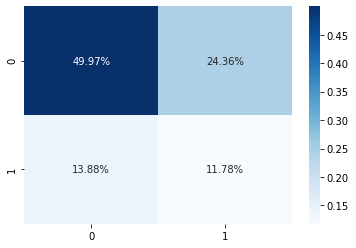

In [6]:
svm_text(df)

## Numeric features from dataset

In [7]:
def svm_initial_features(df):  
    categorical_features = ['cohort', 'field', 'prior_educ', 'previously_enrolled', 'multiple_requests', 'gender',
                                'interest', 'ase', 'year', 'program']
    numeric_features = ['age', 'HSGPA']
    
    df_numeric = pd.concat([df[categorical_features], df[numeric_features]], axis=1)
    
    df1_train = df_train[categorical_features]
    df2_train = df_train[numeric_features]
    X_train = pd.concat([df1_train, df2_train], axis=1)
    y_train = df_train['bsa_dummy']
    
    df1_test = df_test[categorical_features]
    df2_test = df_test[numeric_features]
    X_test = pd.concat([df1_test, df2_test], axis=1)
    y_test = df_test['bsa_dummy']


      
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

 
    pipe = make_pipeline(preprocessor,                         
                         SVC(kernel='linear', class_weight='balanced', random_state=0))
    
    scores = cross_val_score(pipe, df_numeric, df['bsa_dummy'], cv=5)

    print('5-fold cross validation scores:', scores)
    print('average of 5-fold cross validation scores:', scores.mean())

    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    print("Accuracy for SVM on test_set: %s" % accuracy_score(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    print(classification_report(y_test, predictions))

  
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()
    
    
    

     

5-fold cross validation scores: [0.62747875 0.60552408 0.63031161 0.62535411 0.60056657]
average of 5-fold cross validation scores: 0.6178470254957507
Accuracy for SVM on test_set: 0.6050991501416431
              precision    recall  f1-score   support

           0       0.84      0.58      0.68      1312
           1       0.36      0.69      0.47       453

    accuracy                           0.61      1765
   macro avg       0.60      0.63      0.58      1765
weighted avg       0.72      0.61      0.63      1765



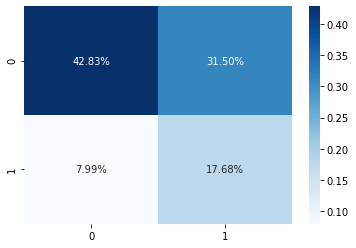

In [8]:
svm_initial_features(df)

# Numeric + text

In [11]:
def svm_text_numeric(df):
    stopword_list = list(stopwords.words('Dutch'))
    df['motivation'] = df['motivation'].str.replace('\d+', '', regex=True)


    df = df.fillna(method='ffill')
    categorical_features = ['cohort', 'field', 'prior_educ', 'previously_enrolled', 'multiple_requests', 'gender',
                                'interest', 'ase', 'year', 'program']
    numeric_features = ['age', 'HSGPA']
    
    text_features = ['motivation']
    
    target = df['bsa_dummy']
    
    get_text_data = FunctionTransformer(lambda x: x['motivation'], validate=False)
    get_numeric_data = FunctionTransformer(lambda x: x[numeric_features], validate=False)
    get_categorical_data = FunctionTransformer(lambda x: x[categorical_features], validate=False)
    
    df1_train = df_train[categorical_features]
    df2_train = df_train[numeric_features]
    df3_train = df_train[text_features]
    X_train_temp = pd.concat([df1_train, df2_train], axis=1)
    X_train = pd.concat([X_train_temp, df3_train], axis=1)

    y_train = df_train['bsa_dummy']
    
    df1_test = df_test[categorical_features]
    df2_test = df_test[numeric_features]
    df3_test = df_test[text_features]
    X_test_temp = pd.concat([df1_test, df2_test], axis=1)
    X_test = pd.concat([X_test_temp, df3_test], axis=1)

    y_test = df_test['bsa_dummy']

    process_and_join_features = Pipeline([
        ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('scaler', preprocessing.StandardScaler())

            ])),
            ('categorical_features', Pipeline([
                ('selector', get_categorical_data),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))

            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('vec', TfidfVectorizer(lowercase=True, stop_words=stopword_list))
                
            ]))
        ])),


        ('clf', SVC(kernel = 'linear', class_weight='balanced', random_state=0))
    ])
    
    
    
    text = df['motivation']
    num = df[numeric_features]
    cat = df[categorical_features]
    df_features =pd.concat([text,num], axis=1)
    df_features =pd.concat([df_features,cat], axis=1)

         
    # Cross validation
    scores = cross_val_score(process_and_join_features, df_features, df['bsa_dummy'], cv=5)
    print('5-fold cross validation scores:', scores)
    print('average of 5-fold cross validation scores:', scores.mean())
    
    print("**********************************************")

    
    # Check testset
    process_and_join_features.fit(X_train, y_train)
    predictions = process_and_join_features.predict(X_test)
    X_test['predictions'] = predictions
    print("Accuracy for SVM on test_set: %s" % accuracy_score(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    print(classification_report(y_test, predictions))  
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()
    


5-fold cross validation scores: [0.65014164 0.65934844 0.65084986 0.65934844 0.64022663]
average of 5-fold cross validation scores: 0.6519830028328611
**********************************************
Accuracy for SVM on test_set: 0.6390934844192635
              precision    recall  f1-score   support

           0       0.81      0.67      0.74      1312
           1       0.36      0.54      0.43       453

    accuracy                           0.64      1765
   macro avg       0.59      0.61      0.58      1765
weighted avg       0.69      0.64      0.66      1765



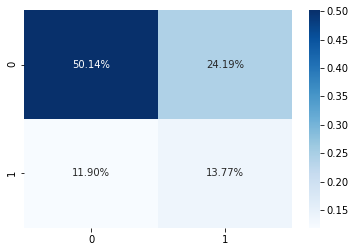

In [12]:
svm_text_numeric(df)

## numeric feature+ extracted features

In [13]:
def svm_all_nontext_features(df, df_train, df_test):
    categorical_features = ['cohort', 'field', 'prior_educ', 'previously_enrolled', 'multiple_requests', 'gender',
                                'interest', 'ase', 'year', 'program']
    numeric_features = ['age', 'HSGPA', 'WC', 'WPS', 'Sixltr',
                            'Dic', 'funct', 'pronoun', 'ppron', 'i',
                            'we', 'you', 'shehe', 'they', 'ipron',
                            'article', 'verb', 'auxverb', 'past', 'present',
                            'future', 'adverb', 'preps', 'conj', 'negate',
                            'quant', 'number', 'swear', 'social', 'family',
                            'friend', 'humans', 'affect', 'posemo', 'negemo',
                            'anx', 'anger', 'sad', 'cogmech', 'insight',
                            'cause', 'discrep', 'tentat', 'certain', 'inhib',
                            'incl', 'excl', 'percept', 'see', 'hear',
                            'feel', 'bio', 'body', 'health', 'sexual',
                            'ingest', 'relativ', 'motion', 'space', 'time',
                            'work', 'achieve', 'leisure', 'home', 'money',
                            'relig', 'death', 'assent', 'nonfl', 'filler',
                            'pronadv', 'shehethey', 'AllPunc', 'Period', 'Comma',
                            'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash',
                            'Quote', 'Apostro', 'Parenth', 'OtherP', 'count_punct',
                            'count_stopwords', 'nr_token', 'nr_adj', 'nr_noun', 'nr_verb',
                            'nr_number', 'topic1', 'topic2', 'topic3', 'topic4',
                            'topic5', 'topic6', 'topic7', 'topic8', 'topic9',
                            'topic10', 'topic11', 'topic12', 'topic13', 'topic14',
                            'topic15']

   
    df_numeric = pd.concat([df[categorical_features], df[numeric_features]], axis=1)
    

    df1_train = df_train[categorical_features]
    df2_train = df_train[numeric_features]
    X_train = pd.concat([df1_train, df2_train], axis=1)
    y_train = df_train['bsa_dummy']
    
    df1_test = df_test[categorical_features]
    df2_test = df_test[numeric_features]
    X_test = pd.concat([df1_test, df2_test], axis=1)
    y_test = df_test['bsa_dummy']

        
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

 
    pipe = make_pipeline(preprocessor,                         
                         SVC(kernel = 'linear', class_weight='balanced', random_state=0))
    
    scores = cross_val_score(pipe, df_numeric, df['bsa_dummy'], cv=5)

    print('5-fold cross validation scores:', scores)
    print('average of 5-fold cross validation scores:', scores.mean())

    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    print("Accuracy for SVM on test_set: %s" % accuracy_score(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    print(classification_report(y_test, predictions))

  
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()
    
    # Extract feature importance
    importance = pipe.steps[1][1].coef_
    feature_names = numeric_features + categorical_features

    # Zip feature importance and feature names in the format of dictionary
    coef_dict = {}
    for coef, feat in zip(pipe.steps[1][1].coef_[0, :], feature_names):
        coef_dict[feat] = coef

    # Sort feature_importance values
    coef_dict = dict(sorted(coef_dict.items(), key=lambda item: item[1]))

    # Turn dictionary to series
    feature_importance = pd.Series(list(coef_dict.values()), index=coef_dict.keys())

    # Plot feature importance
    feature_importance.plot.barh(figsize=(15, 25))
    plt.show()



5-fold cross validation scores: [0.62818697 0.62252125 0.6203966  0.62322946 0.60835694]
average of 5-fold cross validation scores: 0.6205382436260624
Accuracy for SVM on test_set: 0.623229461756374
              precision    recall  f1-score   support

           0       0.83      0.62      0.71      1312
           1       0.37      0.64      0.47       453

    accuracy                           0.62      1765
   macro avg       0.60      0.63      0.59      1765
weighted avg       0.71      0.62      0.65      1765



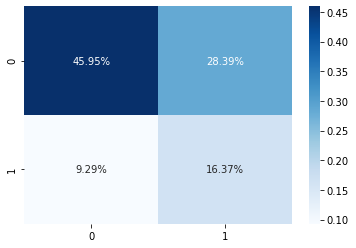

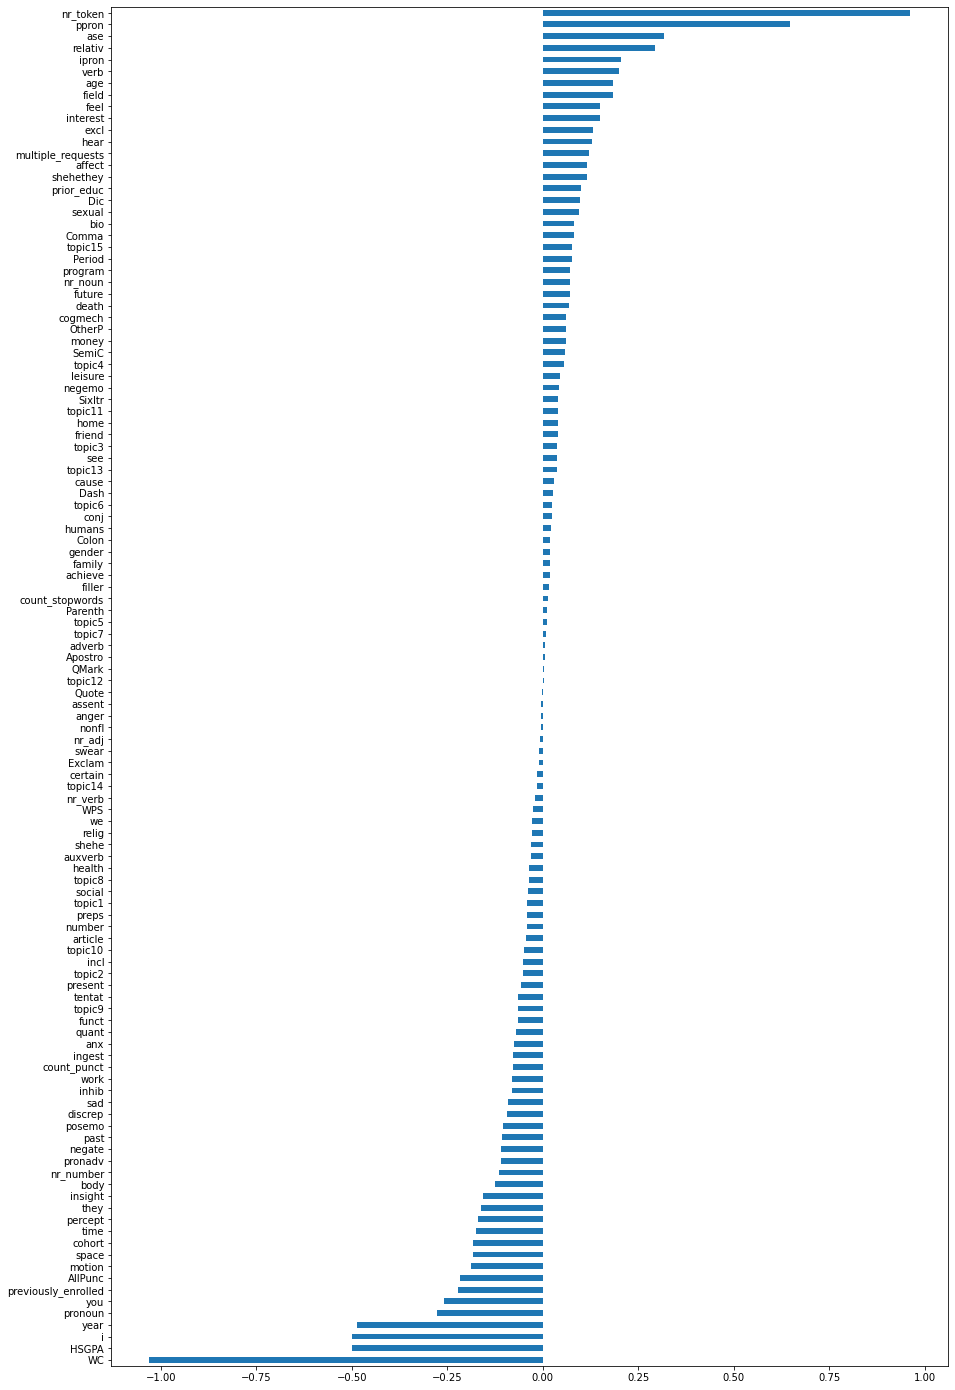

In [14]:
svm_all_nontext_features(df, df_train, df_test)

## Text + All numeric

5-fold cross validation scores: [0.65509915 0.65439093 0.66288952 0.66926346 0.65580737]
average of 5-fold cross validation scores: 0.6594900849858357
**********************************************
Accuracy for SVM on test_set: 0.6447592067988669
              precision    recall  f1-score   support

           0       0.81      0.68      0.74      1312
           1       0.37      0.54      0.44       453

    accuracy                           0.64      1765
   macro avg       0.59      0.61      0.59      1765
weighted avg       0.70      0.64      0.66      1765



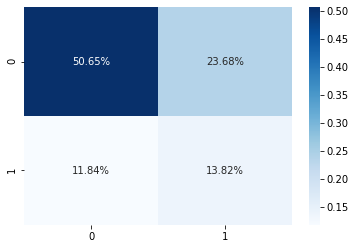

**********************************************

100-Features with highest tfidf:

['utrecht', 'studie', 'opleiding', 'vind', 'erg', 'leuk', 'universiteit', 'gaan', 'goed', 'gekozen', 'lijkt', 'hbo', 'wel', 'universitaire', 'graag', 'interessant', 'minder', 'studeren', 'jaar', 'heel', 'denk', 'waar', 'vakken', 'keuze', 'stad', 'mensen', 'maken', 'leren', 'spreekt', 'weet', 'verschillende', 'verder', 'eerste', 'school', 'vooral', 'daarnaast', 'aspecten', 'kies', 'vond', 'werken', 'volgen', 'leuke', 'alleen', 'open', 'geïnteresseerd', 'hoop', 'daarom', 'kiezen', 'later', 'mee', 'goede', 'dingen', 'echt', 'vwo', 'vak', 'past', 'tussen', 'zoals', 'aanspreekt', 'vinden', 'beter', 'komen', 'zeker', 'tijdens', 'interesse', 'meest', 'middelbare', 'bijvoorbeeld', 'waarom', 'dag', 'gaat', 'rechtsgeleerdheid', 'kennis', 'tijd', 'niveau', 'bezig', 'reden', 'studies', 'manier', 'willen', 'af', 'ga', 'wilde', 'zit', 'natuurlijk', 'alle', 'uiteindelijk', 'zeer', 'gedaan', 'fijn', 'rechten', 'studenten

Features with highest tfidf:
['geografie' 'onwijs' 'milieu' 'informatiekunde' 'maatschappij'
 'formulier' 'allerlei' 'aspecten' 'bereik' 'boeken' 'volk' 'adviseren'
 'gewend' 'verleden' 'vind' 'opleiding' 'nijmegen' 'kanten'
 'keuzevrijheid' 'literatuurwetenschap' 'journalistiek' 'amsterdam'
 'nederland' 'schrijfacademie' 'aardrijkskunde' 'farmacie' 'natuurkundige'
 'aruba' 'wetenschappen' 'persoonlijke' 'overstap' 'omstandigheden'
 'website' 'rechtsgeleerdheid' 'facility' 'vooropleiding' 'behoefte'
 'vanaf' 'levendig' 'rechten' 'theater' 'bedrijf' 'vergelijkbare' 'erbij'
 'anderhalf' 'series' 'psychologie' 'maastricht' 'film' 'conservatorium'
 'erna' 'taal' 'wijsbegeerte' 'rechter' 'ziekte' 'cultuur' 'oefenen'
 'interdisciplinair' 'onderwijs' 'erasmus' 'wegens' 'situatie' 'medisch'
 'lichaam' 'onderwijskunde' 'pabo' 'sociale' 'keus' 'regels'
 'oudheidkunde' 'bèta' 'gametechnologie' 'cosmetische' 'intelligentie'
 'kunstmatige' 'tcs' 'nyenrode' 'tu' 'ict' 'verhuizing' 'muziekwetenschap'

In [16]:
def svm_all_features(df):
    stopword_list = list(stopwords.words('Dutch'))
    df['motivation'] = df['motivation'].str.replace('\d+', '', regex=True)


    df = df.fillna(method='ffill')
    categorical_features = ['cohort', 'field', 'prior_educ', 'previously_enrolled', 'multiple_requests', 'gender',
                                'interest', 'ase', 'year', 'program']
    numeric_features = ['age', 'HSGPA', 'WC', 'WPS', 'Sixltr',
                        'Dic', 'funct', 'pronoun', 'ppron', 'i',
                        'we', 'you', 'shehe', 'they', 'ipron',
                        'article', 'verb', 'auxverb', 'past', 'present',
                        'future', 'adverb', 'preps', 'conj', 'negate',
                        'quant', 'number', 'swear', 'social', 'family',
                        'friend', 'humans', 'affect', 'posemo', 'negemo',
                        'anx', 'anger', 'sad', 'cogmech', 'insight',
                        'cause', 'discrep', 'tentat', 'certain', 'inhib',
                        'incl', 'excl', 'percept', 'see', 'hear',
                        'feel', 'bio', 'body', 'health', 'sexual',
                        'ingest', 'relativ', 'motion', 'space', 'time',
                        'work', 'achieve', 'leisure', 'home', 'money',
                        'relig', 'death', 'assent', 'nonfl', 'filler',
                        'pronadv', 'shehethey', 'AllPunc', 'Period', 'Comma',
                        'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash',
                        'Quote', 'Apostro', 'Parenth', 'OtherP', 'count_punct',
                        'count_stopwords', 'nr_token', 'nr_adj', 'nr_noun', 'nr_verb',
                        'nr_number', 'topic1', 'topic2', 'topic3', 'topic4',
                        'topic5', 'topic6', 'topic7', 'topic8', 'topic9',
                        'topic10', 'topic11', 'topic12', 'topic13', 'topic14',
                        'topic15']
    text_features = ['motivation']
    
    target = df['bsa_dummy']
    
    get_text_data = FunctionTransformer(lambda x: x['motivation'], validate=False)
    get_numeric_data = FunctionTransformer(lambda x: x[numeric_features], validate=False)
    get_categorical_data = FunctionTransformer(lambda x: x[categorical_features], validate=False)
    
    df1_train = df_train[categorical_features]
    df2_train = df_train[numeric_features]
    df3_train = df_train[text_features]
    X_train_temp = pd.concat([df1_train, df2_train], axis=1)
    X_train = pd.concat([X_train_temp, df3_train], axis=1)

    y_train = df_train['bsa_dummy']
    
    df1_test = df_test[categorical_features]
    df2_test = df_test[numeric_features]
    df3_test = df_test[text_features]
    X_test_temp = pd.concat([df1_test, df2_test], axis=1)
    X_test = pd.concat([X_test_temp, df3_test], axis=1)

    y_test = df_test['bsa_dummy']

    process_and_join_features = Pipeline([
        ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('scaler', preprocessing.StandardScaler())

            ])),
            ('categorical_features', Pipeline([
                ('selector', get_categorical_data),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))

            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('vec', TfidfVectorizer(lowercase=True, stop_words=stopword_list))
                
            ]))
        ])),


        ('clf', SVC(kernel = 'linear', class_weight='balanced', random_state=0))
    ])
    
    
    
    text = df['motivation']
    num = df[numeric_features]
    cat = df[categorical_features]
    df_features =pd.concat([text,num], axis=1)
    df_features =pd.concat([df_features,cat], axis=1)

         
    # Cross validation
    scores = cross_val_score(process_and_join_features, df_features, df['bsa_dummy'], cv=5)
    print('5-fold cross validation scores:', scores)
    print('average of 5-fold cross validation scores:', scores.mean())
    
    print("**********************************************")

    
    # Check testset
    process_and_join_features.fit(X_train, y_train)
    predictions = process_and_join_features.predict(X_test)
    # Write predictions in the dataset
    X_test['predictions'] = predictions
    print("Accuracy for SVM on test_set: %s" % accuracy_score(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    print(classification_report(y_test, predictions))  
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show()
    
    print("**********************************************")
    


    print("\n100-Features with highest tfidf:\n")
    indices = np.argsort(dict(process_and_join_features.named_steps['features'].transformer_list).get('text_features').named_steps[
        'vec'].idf_)[:-1]
    
    features = dict(process_and_join_features.named_steps['features'].transformer_list).get('text_features').named_steps[
        'vec'].get_feature_names()
    top_n = 100
    top_features = [features[i] for i in indices[:top_n]]
    print( top_features)  
    
    print("**********************************************")

    
    # concatenate X_test with labels
    final_ds = pd.concat([X_test, y_test], axis=1)
    
    
        
    # Features with highest tfidf for dropout students 
    print("\nFeatures with highest tfidf for dropout students:\n")
    df_dropout = final_ds[final_ds['bsa_dummy']==1]
    vectorizer = TfidfVectorizer(lowercase=True, stop_words=stopword_list)
    X = vectorizer.fit_transform(df_dropout['motivation'])
    max_value = X.max(axis=0).toarray().ravel()
    sorted_by_tfidf = max_value.argsort()
    feature_names = np.array(vectorizer.get_feature_names())
    print("Features with highest tfidf:\n{}".format(feature_names[sorted_by_tfidf[-100:]]))
    
    
    # Features with highest tfidf for dropout predicted students 
    print("\nFeatures with highest tfidf for dropout predicted students:\n")
    df_dropout = final_ds[final_ds['predictions']==1]
    vectorizer = TfidfVectorizer(lowercase=True, stop_words=stopword_list)
    X = vectorizer.fit_transform(df_dropout['motivation'])
    max_value = X.max(axis=0).toarray().ravel()
    sorted_by_tfidf = max_value.argsort()
    feature_names = np.array(vectorizer.get_feature_names())
    print("Features with highest tfidf:\n{}".format(feature_names[sorted_by_tfidf[-100:]]))
    
    # Features with highest tfidf for dropout predicted students (correct prediction)
    print("\nTop frequent words for dropout predicted students (correct prediction):\n")
    df_dropout = final_ds[(final_ds['predictions']==1) & (final_ds['bsa_dummy']==1)]
    vectorizer = TfidfVectorizer(lowercase=True, stop_words=stopword_list)
    X = vectorizer.fit_transform(df_dropout['motivation'])
    max_value = X.max(axis=0).toarray().ravel()
    sorted_by_tfidf = max_value.argsort()
    feature_names = np.array(vectorizer.get_feature_names())
    print("Features with highest tfidf:\n{}".format(feature_names[sorted_by_tfidf[-100:]]))
    
    # Features with highest tfidf for dropout predicted students (False prediction)
    print("\nFeatures with highest tfidf for dropout predicted students (False prediction):\n")
    df_dropout = final_ds[(final_ds['predictions']==1) & (final_ds['bsa_dummy']==0)]
    vectorizer = TfidfVectorizer(lowercase=True, stop_words=stopword_list)
    X = vectorizer.fit_transform(df_dropout['motivation'])
    max_value = X.max(axis=0).toarray().ravel()
    sorted_by_tfidf = max_value.argsort()
    feature_names = np.array(vectorizer.get_feature_names())
    print("Features with highest tfidf:\n{}".format(feature_names[sorted_by_tfidf[-100:]]))
    
    print("**********************************************")
        
    # Features with highest tfidf for non-dropout students 
    print("\nFeatures with highest tfidf for non-dropout students:\n")
    df_dropout = final_ds[final_ds['bsa_dummy']==0]
    vectorizer = TfidfVectorizer(lowercase=True, stop_words=stopword_list)
    X = vectorizer.fit_transform(df_dropout['motivation'])
    max_value = X.max(axis=0).toarray().ravel()
    sorted_by_tfidf = max_value.argsort()
    feature_names = np.array(vectorizer.get_feature_names())
    print("Features with highest tfidf:\n{}".format(feature_names[sorted_by_tfidf[-100:]]))
    
    
    # Features with highest tfidf for non-dropout predicted students 
    print("\nFeatures with highest tfidf for non-dropout predicted students:\n")
    df_dropout = final_ds[final_ds['predictions']==0]
    vectorizer = TfidfVectorizer(lowercase=True, stop_words=stopword_list)
    X = vectorizer.fit_transform(df_dropout['motivation'])
    max_value = X.max(axis=0).toarray().ravel()
    sorted_by_tfidf = max_value.argsort()
    feature_names = np.array(vectorizer.get_feature_names())
    print("Features with highest tfidf:\n{}".format(feature_names[sorted_by_tfidf[-100:]]))
    
    # ("Features with highest tfidf for non-dropout predicted students (correct prediction)
    print("\n(Features with highest tfidf for non-dropout predicted students (correct prediction):\n")
    df_dropout = final_ds[(final_ds['predictions']==0) & (final_ds['bsa_dummy']==0)]
    vectorizer = TfidfVectorizer(lowercase=True, stop_words=stopword_list)
    X = vectorizer.fit_transform(df_dropout['motivation'])
    max_value = X.max(axis=0).toarray().ravel()
    sorted_by_tfidf = max_value.argsort()
    feature_names = np.array(vectorizer.get_feature_names())
    print("Features with highest tfidf:\n{}".format(feature_names[sorted_by_tfidf[-100:]]))
    
    # Features with highest tfidf for non-dropout predicted students (False prediction)
    print("\nFeatures with highest tfidf for non-dropout students (False prediction):\n")
    df_dropout = final_ds[(final_ds['predictions']==0) & (final_ds['bsa_dummy']==1)]
    vectorizer = TfidfVectorizer(lowercase=True, stop_words=stopword_list)
    X = vectorizer.fit_transform(df_dropout['motivation'])
    max_value = X.max(axis=0).toarray().ravel()
    sorted_by_tfidf = max_value.argsort()
    feature_names = np.array(vectorizer.get_feature_names())
    print("Features with highest tfidf:\n{}".format(feature_names[sorted_by_tfidf[-100:]]))
    
svm_all_features(df)